# **Project Computer Vision SpaceJam**

di Emilio Casella matr.204898

In [1]:
import os
import json
import time
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
from sklearn.metrics import accuracy_score
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on %s' % device)

run on cuda


Per prima cosa, carichiamo tutto ciò che ci serve per l'analisi del dataset relativo al progetto SpaceJam. Si ricorda di seguire le istruzioni, elencate nel dettaglio nel file README,  per un opportuno caricamento dei file in oggetto.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp -avr 'drive/My Drive/ProgettoCV204898/dataset.zip' ./
!cp -f 'drive/My Drive/ProgettoCV204898/testset_keys_1lug2020.txt' ./
!unzip -qq './dataset.zip' -d './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'drive/My Drive/ProgettoCV204898/dataset.zip' -> './dataset.zip'


In [3]:
PATH='./'
DATASET_DIR = './dataset/'
DATASET_FILES = './dataset/examples/'
KEYSET_FILE = './testset_keys_1lug2020.txt'


LABELS = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk"}


with open(os.path.join(DATASET_DIR, 'annotation_dict.json')) as fp:
    annotations = json.load(fp)

with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))

len(annotations), len(annotationTrain), len(annotationTest)


(37085, 25959, 11126)

Il dataset da analizzare è composto da file video in formato mp4.

25959 sample per la fase di train/validation, 11126 sample per la fase di test.

L'immagine sottostante mostra come appare un video in esame, qui in particolare viene raffigurato un atleta nella fase di no_action.

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(os.path.join(DATASET_FILES, '0018414.mp4'),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=200 controls loop autoplay>>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Si passa ora alla divisione del dataset in train set, validation set e test set sulla base delle indicazioni ricevute.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(list(annotationTrain.keys()), list(annotationTrain.values()), test_size=0.02, random_state=42)
X_test,y_test=list(annotationTest.keys()),list(annotationTest.values())


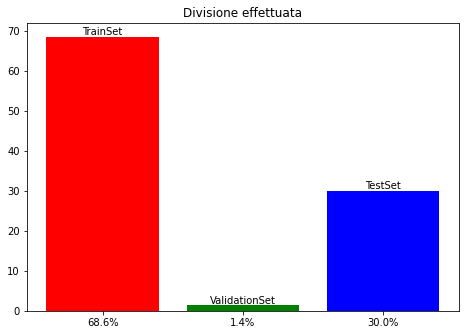

In [5]:
objects=['TrainSet','ValidationSet','TestSet']

a=(len(X_train)/(len(X_train)+len(X_val)+len(X_test)))
b=(len(X_val)/(len(X_train)+len(X_val)+len(X_test)))
c=(len(X_test)/(len(X_train)+len(X_val)+len(X_test)))

y_pos=[round(a*100,2),round(b*100,2),round(c*100,2)]
l=[str(round(a*100,2))+"%",str(round(b*100,2))+"%",str(round(c*100,2))+"%"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(objects,y_pos,color=['red','green','blue'])

ax.set_title('Divisione effettuata')
ax.set_xticklabels(l)
rects = ax.patches



for rect, label in zip(rects, objects):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
plt.show()


Il train set è rappresentato dal 68,6% delle immagini, con 1,4% di validation set e il restante 30% di test set.

Visualizziamo, più nel dettaglio, la distibuzione delle immagini per ogni classe:

L'andamento della distribuzione degli esempi è la medesima su tutti gli insiemi, effettuata con un'opportuna ratio dal metodo train_test_split.

Si noti, però, che il numero di sample per ogni classe non è uniforme, con pochi elementi nelle classi shoot,pick e una numerosità più elevata nelle classi run, no_action e walk.

Siamo di fronte ad un dataset sbilanciato, da trattare opportunamente nella fase di learning del modello oggetto di studio.

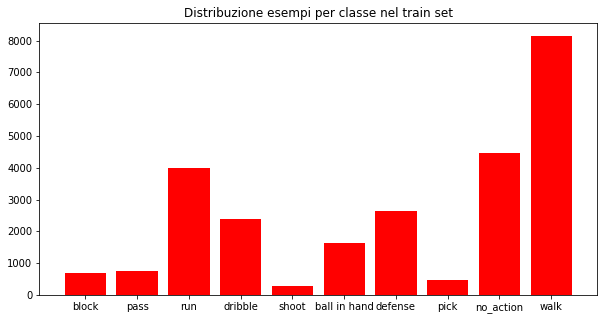

In [6]:
et=list(LABELS.values())
train=list(np.bincount(y_train))

diz={}
for i in range(0,len(et)):
  diz[et[i]]=train[i]

c = list(diz.keys()) 
v = list(diz.values()) 

fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(c, v,color='red') 
plt.title("Distribuzione esempi per classe nel train set") 

plt.show()

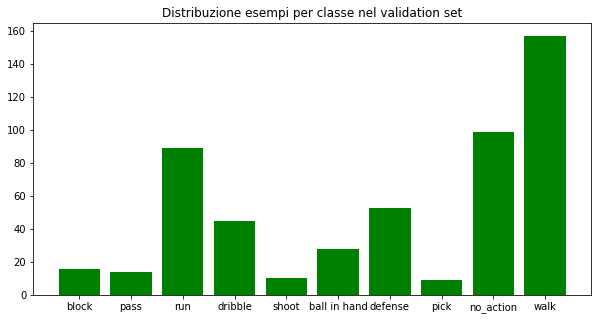

In [7]:
val=list(np.bincount(y_val))

diz={}
for i in range(0,len(et)):
  diz[et[i]]=val[i]

c = list(diz.keys()) 
v = list(diz.values()) 

fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(c, v,color='green') 
plt.title("Distribuzione esempi per classe nel validation set") 

plt.show()

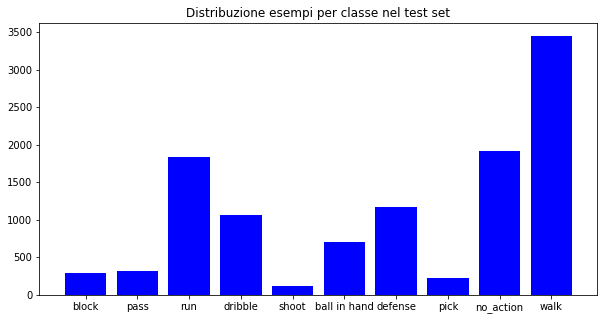

In [8]:
test=list(np.bincount(y_test))

diz={}
for i in range(0,len(et)):
  diz[et[i]]=test[i]

c = list(diz.keys()) 
v = list(diz.values()) 

fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(c, v,color='blue') 
plt.title("Distribuzione esempi per classe nel test set") 

plt.show()

# Modello: **S3D**

In [48]:
from IPython.display import Image

!cp -f 'drive/My Drive/ProgettoCV204898/1.PNG' ./
!cp -f 'drive/My Drive/ProgettoCV204898/2.PNG' ./
!cp -f 'drive/My Drive/ProgettoCV204898/3.PNG' ./
!cp -f 'drive/My Drive/ProgettoCV204898/4.PNG' ./

La mia idea iniziale era quella di utilizzare una rete I3D che presenta molte implementazioni online facilmenti accessibili https://github.com/piergiaj/pytorch-i3d ;tuttavia dopo essermi imbattuto nella lettura dell'articolo 
https://arxiv.org/pdf/1712.04851.pdf, ho capito che si potesse fare ancora meglio.

Viene presentata un'ottimizzazione della rete I3D, denominata S3D.
Si passa a catturare l'informazione temporale con pochi filtri 3D, rimpiazzandoli con 2D meno costosi.

Il primo passo che compiono gli autori è un "network surgery", rimuovendo  i filtri 3D, con la creazione della variante Bottom-Heavy-I3D, con filtri 3D posti all'inizio della rete e 2D posti in prossimità dell'output; e della variante Top-Heavy-I3D che fa il viceversa.
La Top-Heavy-I3D ottiene il miglior risultato.

Successivamente, al fine di separare il concetto di spazio da quello di tempo,
si rimpiazzano, in modo tale da "alleggerire" la rete, i filtri 3D con una cascata di 2 filtri  kt×k×k→(1×k×k,kt×1×1).
In particolar modo, se ne utilizza uno per separare in termini temporali e uno per separare in termini spaziali; abbassando ulteriormente i costi.

Infine, per rendere la rete più robusta rispetto all'overfitting, si utilizza un modulo inception opportunamente modificato; con l'uso di più filtri convoluzionali contemporaneamente e concatenando l'output.








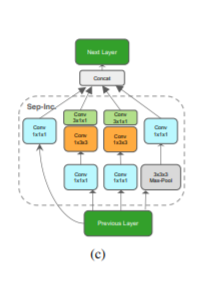

In [50]:
Image("./1.PNG")

S3D, come si può ammirare dal grafico sottostante si comporta decisamente meglio di tutto il resto.

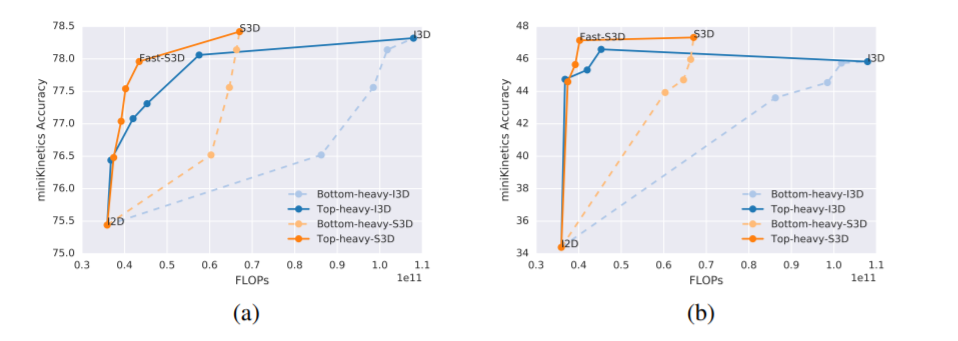

In [51]:
Image("./2.PNG")

Il fatto che le statistiche riportate precedentemente fossero preallenate su un dataset kinetics, mi ha mostrato chiaramente il percorso che avrei dovuto intraprendere.

E' possibile accedere ad un'ottima implementazione della rete S3D tramite la repository https://github.com/kylemin/S3D, dove si presenta una rete addestrata con transfer learning su Kinetics 400, ottendendo performance vicine al 72% di accuratezza.


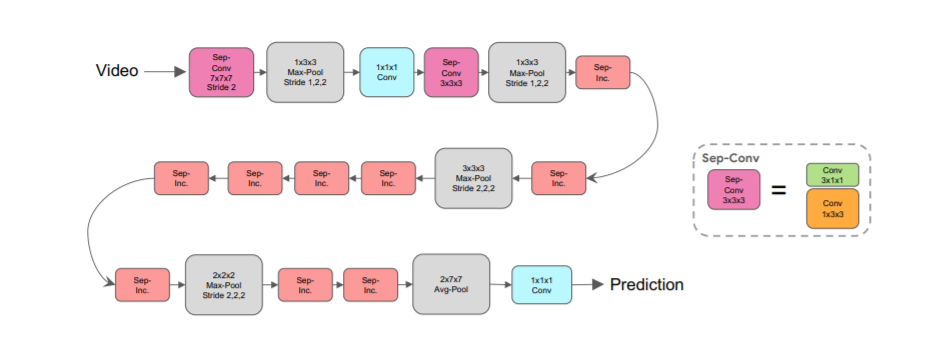

In [54]:
Image("./3.PNG")

In [22]:
import torch
from torch import nn
import torch.nn.functional as F
 
class S3D(nn.Module):
    def __init__(self, num_class):
        super(S3D, self).__init__()
        self.base = nn.Sequential(
            SepConv3d(3, 64, kernel_size=7, stride=2, padding=3),                           #Sep-Conv7x7x7
            nn.MaxPool3d(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1)),             #1x3x3 MaxPool
            BasicConv3d(64, 64, kernel_size=1, stride=1),                                   #1x1x1 Conv
            SepConv3d(64, 192, kernel_size=3, stride=1, padding=1),                         #Sep-Conv 3x3x3 (Conv3D 1x3x3->Conv3D 3x1x1)
            nn.MaxPool3d(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1)),             #1x3x3 MaxPool
            Mixed_3b(),
            Mixed_3c(),
            nn.MaxPool3d(kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
            Mixed_4b(),
            Mixed_4c(),
            Mixed_4d(),
            Mixed_4e(),
            Mixed_4f(),
            nn.MaxPool3d(kernel_size=(2,2,2), stride=(2,2,2), padding=(0,0,0)),
            Mixed_5b(),
            Mixed_5c(),
        )
        self.fc = nn.Sequential(nn.Conv3d(1024, num_class, kernel_size=1, stride=1, bias=True),)
 
    def forward(self, x):
        y = self.base(x)
        y = F.avg_pool3d(y, (2, y.size(3), y.size(4)), stride=1)
        y = self.fc(y)
        y = y.view(y.size(0), y.size(1), y.size(2))
        logits = torch.mean(y, 2)
 
        return logits

In [23]:
class BasicConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv3d, self).__init__()
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu = nn.ReLU()
 
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [24]:
class SepConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(SepConv3d, self).__init__()
        self.conv_s = nn.Conv3d(in_planes, out_planes, kernel_size=(1,kernel_size,kernel_size), stride=(1,stride,stride), padding=(0,padding,padding), bias=False)
        self.bn_s = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu_s = nn.ReLU()
 
        self.conv_t = nn.Conv3d(out_planes, out_planes, kernel_size=(kernel_size,1,1), stride=(stride,1,1), padding=(padding,0,0), bias=False)
        self.bn_t = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu_t = nn.ReLU()
 
    def forward(self, x):
        x = self.conv_s(x)
        x = self.bn_s(x)
        x = self.relu_s(x)
 
        x = self.conv_t(x)
        x = self.bn_t(x)
        x = self.relu_t(x)
        return x

In [25]:
class Mixed_3b(nn.Module):
    def __init__(self):
        super(Mixed_3b, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(192, 64, kernel_size=1, stride=1),                        #Branch 1x1x1
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(192, 96, kernel_size=1, stride=1),                        #Branch 1x1x1
            SepConv3d(96, 128, kernel_size=3, stride=1, padding=1),               #Conv3Dx3x3->Conv3D 3x1x1
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(192, 16, kernel_size=1, stride=1),                        #Branch 1x1x1
            SepConv3d(16, 32, kernel_size=3, stride=1, padding=1),                #Conv3Dx3x3->Conv3D 3x1x1
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),               #Branch MaxPool 3x3x3
            BasicConv3d(192, 32, kernel_size=1, stride=1),                        #Conv3D1x1x1
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)                                      
 
        return out
 

In [26]:
class Mixed_3c(nn.Module):
    def __init__(self):
        super(Mixed_3c, self).__init__()
        self.branch0 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
            SepConv3d(128, 192, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(256, 32, kernel_size=1, stride=1),
            SepConv3d(32, 96, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(256, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [27]:
class Mixed_4b(nn.Module):
    def __init__(self):
        super(Mixed_4b, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(480, 192, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(480, 96, kernel_size=1, stride=1),
            SepConv3d(96, 208, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(480, 16, kernel_size=1, stride=1),
            SepConv3d(16, 48, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(480, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [28]:
class Mixed_4c(nn.Module):
    def __init__(self):
        super(Mixed_4c, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(512, 160, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
            SepConv3d(112, 224, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            SepConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

In [29]:
class Mixed_4d(nn.Module):
    def __init__(self):
        super(Mixed_4d, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
            SepConv3d(128, 256, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            SepConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [30]:
class Mixed_4e(nn.Module):
    def __init__(self):
        super(Mixed_4e, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 144, kernel_size=1, stride=1),
            SepConv3d(144, 288, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 32, kernel_size=1, stride=1),
            SepConv3d(32, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [31]:
class Mixed_4f(nn.Module):
    def __init__(self):
        super(Mixed_4f, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(528, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(528, 160, kernel_size=1, stride=1),
            SepConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(528, 32, kernel_size=1, stride=1),
            SepConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(528, 128, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

In [32]:
class Mixed_5b(nn.Module):
    def __init__(self):
        super(Mixed_5b, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(832, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 160, kernel_size=1, stride=1),
            SepConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 32, kernel_size=1, stride=1),
            SepConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [33]:
class Mixed_5c(nn.Module):
    def __init__(self):
        super(Mixed_5c, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(832, 384, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 192, kernel_size=1, stride=1),
            SepConv3d(192, 384, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 48, kernel_size=1, stride=1),
            SepConv3d(48, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

In [34]:
from torchsummary import summary
summary(S3D(10).cuda(), (3,16, 150, 120))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 16, 75, 60]           9,408
       BatchNorm3d-2       [-1, 64, 16, 75, 60]             128
              ReLU-3       [-1, 64, 16, 75, 60]               0
            Conv3d-4        [-1, 64, 8, 75, 60]          28,672
       BatchNorm3d-5        [-1, 64, 8, 75, 60]             128
              ReLU-6        [-1, 64, 8, 75, 60]               0
         SepConv3d-7        [-1, 64, 8, 75, 60]               0
         MaxPool3d-8        [-1, 64, 8, 38, 30]               0
            Conv3d-9        [-1, 64, 8, 38, 30]           4,096
      BatchNorm3d-10        [-1, 64, 8, 38, 30]             128
             ReLU-11        [-1, 64, 8, 38, 30]               0
      BasicConv3d-12        [-1, 64, 8, 38, 30]               0
           Conv3d-13       [-1, 192, 8, 38, 30]         110,592
      BatchNorm3d-14       [-1, 192, 8,

La rete si aspetterà come input immagini RGB composte da 16 frame di dimensione 150x120.


E' stato necessario implementare un DataLoader personalizzato, cercando di ridurre lo sbilanciamento delle classi in fase di train tramite alcuni passi tipici della data augmentation, per mezzo della libreria albumentations; in favore di una maggiore velocità di processamento delle immagini con uso di minori risorse rispetto alla classe transforms di torchivision; che si occuperà solamente della trasformazione in tensore e della normalizzazione dell'immagine.


Entrando più nel dettaglio,nella fase di train ogni frame viene scomposto nelle immagini che lo formano.

Successivamente l'immagine può subire un flip orizzontale, una rotazione,una scalatura, un cambio di luce con probabilità dello 0,5.
Successivamente, quest'ultima subisce un crop che la porta alla dimensione di 150x120; essendo infine trasformata in tensore e normalizzata.

Sui frame inerenti al validation/test set, vengono meno le operazioni di flip, rotazione, scalatura e cambio di luce.

Infine l'immagine viene scomposta nei canali RGB e messa in 3 vettori differenti.

Una volta ultimata l'analisi delle immagini relativa ad uno specifico frame, i 3 vettori vengono uniti e viene restituito il tensore composto da 16 frame a 3 canali con dimensioni 150x120.

In [35]:
from PIL import Image
import torchvision.transforms as T
import albumentations


def augmentation(aug,frame):
  frame=aug(image=np.array(frame))['image']
  return frame

class MyDataLoader(Dataset):
  def __init__(self,X,y,root_dir,par,transform=None):
    self.X=X
    self.y=y
    self.root_dir=root_dir
    self.transform=T.Compose([
                                       T.ToTensor(),
                                       T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                       ])
    self.par=par
    if (par==1):
      self.aug = albumentations.Compose([
                albumentations.HorizontalFlip(p=0.5),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=15,
                    p=0.5
                ),
                albumentations.augmentations.transforms.RandomBrightnessContrast(p=0.5),
                albumentations.augmentations.transforms.CenterCrop(150,120,p=1),
                
            ])
    else:
      self.aug = albumentations.Compose([
                albumentations.augmentations.transforms.CenterCrop(150,120,p=1),
                
                
            ])
    self.ok=[]
    self.okLab=[]
    return

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):
    fname=self.root_dir+self.X[index]+".mp4"
    self.ok.append(self.X[index])
    self.okLab.append(self.y[index])
    video=cv2.VideoCapture(fname)
    image=[]
    r,g,b=[],[],[]
    while True:
      # Capture frame-by-frame
      ret , frame=video.read()
      if ret:
        frame= cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frame=augmentation(self.aug,frame)
        frame= self.transform(frame)
        r1 = frame[0]
        g1 = frame[1]
        b1 = frame[2]
        r1=r1.unsqueeze(0)
        g1=g1.unsqueeze(0)
        b1=b1.unsqueeze(0)
        r.append(r1)
        g.append(g1)
        b.append(b1)
      else:
        break
    r=torch.cat(r)
    g=torch.cat(g)
    b=torch.cat(b)
    image=torch.stack((r,g,b),dim=0)
    return image, self.y[index]
 


Ecco un esempio pratico di come appare un'immagine ricavata dal frame, prima e dopo le operazioni elencate precedentemente.

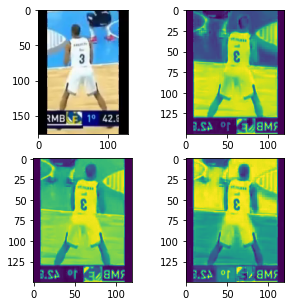

In [ ]:
transform=T.Compose([
                                       T.ToTensor(),
                                       T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                       ])
aug = albumentations.Compose([
                albumentations.HorizontalFlip(p=0.5),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=15,
                    p=0.5
                ),
                albumentations.augmentations.transforms.RandomBrightnessContrast(p=0.5),
                albumentations.augmentations.transforms.CenterCrop(150,120,p=1)
               
                
            ])
image = []
r,g,b=[],[],[]          
fname = os.path.join(DATASET_FILES, '0018414.mp4')
video = cv2.VideoCapture(fname)
while True:
  ret , frame=video.read()
  if ret:
    frame= cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    image.append(frame)
    frame=augmentation(aug,frame)
    frame= transform(frame)
    r1 = frame[0]
    g1 = frame[1]
    b1 = frame[2]
    r1=r1.unsqueeze(0)
    g1=g1.unsqueeze(0)
    b1=b1.unsqueeze(0)
    r.append(r1)
    g.append(g1)
    b.append(b1)
  else:
    break
r=torch.cat(r)
g=torch.cat(g)
b=torch.cat(b)


fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0,0].imshow(image[0])
axs[0,1].imshow(r[0].numpy())
axs[1,0].imshow(g[0].numpy())
axs[1,1].imshow(b[0].numpy())

plt.show()

Si presentano ora i metodi train, validation e test, che si ispirano a quelli visti nel notebook sulle reti convoluzionali, con il compito di analizzare il modello creato.

In [36]:
def train(epoch,steps,print_every,trainLoader,s):
    train_loss=[]
    running_loss = 0
 
    for batch_idx, (inputs, labels) in enumerate(trainLoader): 
        inputs,labels= inputs.to(device), labels.to(device)
        logps = model(inputs)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if (batch_idx+1) % print_every == 0:
            s.append('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}' 
                   .format(epoch, epochs, batch_idx+1, steps, running_loss/(batch_idx*batch_size) ))
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}' 
                   .format(epoch, epochs, batch_idx+1, steps, running_loss/(batch_idx*batch_size)))
 
        train_loss.append(loss.item())
    return np.mean(train_loss)/len(trainLoader)

In [37]:
def validation(model,valLoader,s,ret):
    val_loss = 0
    tp = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valLoader):
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model(inputs)
            ret+=logps
            _, predicted = torch.max(logps, 1)
            tp += (predicted == labels).sum().item()
            loss = criterion(logps,labels)
            val_loss += loss.item()
        val_loss /= len(valLoader.dataset)
        
        s.append('\nVal set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, tp, len(valLoader.dataset),
        100. * tp / len(valLoader.dataset)))
        print('\nVal set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, tp, len(valLoader.dataset),
        100. * tp / len(valLoader.dataset)))
        
    return val_loss,tp / len(valLoader.dataset)

In [38]:
def test(model,testLoader,criterion):
    test_loss = 0
    accuracy = 0
    test_losses=[]
    predictions=[]
    tp=[]
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testLoader):
            inputs, labels= inputs.to(device), labels.to(device)   
            tp+=labels
            logps = model(inputs)
            _, predicted = torch.max(logps, 1)
            predictions+=predicted
            accuracy += (predicted == labels).sum().item()
            loss = criterion(logps,labels)
            test_loss += loss.item()
            
        test_loss /= len(testLoader.dataset)
        test_losses.append(test_loss)
        
    return np.mean(test_losses),accuracy_score(np.array(tp).astype(int),np.array(predictions).astype(int))

Si elencano ora alcuni metodi utili per la creazione,il salvataggio ed il ripristino dei file dump del modello, come richiesto dalle specifiche progettuali.

In [39]:
def start(learning_rate):
    modello,startEpoch,criterion=model(),1,nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(modello.parameters(), lr=learning_rate)
    return modello,startEpoch,optimizer,criterion

def restart(fname):
    model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=loadP(fname)
    print("Carico il modello!")
    return model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output

def salva(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output,FNAME):
     checkP(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output,FNAME)
     print("Salvato!")
    

In [40]:
def model():
  modello=S3D(10)
  modello.cuda()
  modello.to(device)
  return modello


def checkP(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,strings,out,name):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion':criterion,
            'train_loss':train_loss,
            'val_loss':val_loss,
            'val_accs':val_accs,
            'strings':strings,
            'out':out
            }, PATH+name+".model")
  
def loadP(file):
  modello=model()
  checkpoint = torch.load(PATH+file+".model")
  optimizer = torch.optim.Adam(modello.parameters())
  modello.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  criterion = checkpoint['criterion']
  train_loss = checkpoint['train_loss']
  val_loss = checkpoint['val_loss']
  val_accs = checkpoint['val_accs']
  strings=checkpoint['strings']
  out=checkpoint['out']
  return modello,epoch,optimizer,criterion,train_loss,val_loss,val_accs,strings,out

I metodi sotto elencati saranno, invece, utili nell'elaborazione dei grafici e nella fase di analisi.

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

def classify(model,test_loader,criterion):
    test_loss,test_accs=test(model,test_loader,criterion)
    print("L'accuratezza del test vale ", round(test_accs*100,2),"%","con una loss di ",round(test_loss,3))
    predictions=[]
    tl=[]
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images,labels = images.to(device),labels.to(device)
            out = model(images)
            _, predicted = torch.max(out, 1)
            predictions+=[torch.Tensor.cpu(i).detach() for i in predicted]
            tl+=[torch.Tensor.cpu(j).detach() for j in labels]
    return np.array(predictions), np.array(tl)

def graficoL(train_loss,val_loss):
    plt.plot(range(len(train_loss)),train_loss, label='Training loss')
    plt.plot(range(len(val_loss)),val_loss, label='Validation loss')
    plt.legend(frameon=False)
    plt.show() 

def grafico(val_accs):
    plt.plot(range(len(val_accs)),val_accs, label='Accuracy validation set')
    plt.legend(frameon=False)
    plt.show() 



def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sns.heatmap(matrix, 
                annot=True,  
                cmap="YlGnBu")
    plt.show()

Per aumentare le prestazioni della rete, si fa uso del transfer learning;  utilizzando i pesi del modello S3D preaddestrato sul dataset Kinetics(400), con una leggera modifica per adattarlo ad una solo GPU.

Thanks to https://github.com/kylemin/S3D and https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/4

In [42]:
!cp -f 'drive/My Drive/ProgettoCV204898/S3D_Kinetics400.model' ./

In [43]:
from collections import OrderedDict

def tLearning():
  model = S3D(400)
  state_dict = torch.load("./S3D_Kinetics400.model")
  # create new OrderedDict that does not contain `module.`
  from collections import OrderedDict
  new_state_dict = OrderedDict()
 
  for k, v in state_dict.items():
      name = k[7:] # remove `module.`
      new_state_dict[name] = v
 
  model.load_state_dict(new_state_dict)
  model = model.cuda()
  torch.backends.cudnn.benchmark = False
 
  model.fc=nn.Sequential(
      nn.Conv3d(1024, 10, kernel_size=1, stride=1, bias=True))
 
  model_dict = model.state_dict()

  return model

#**Training Modello**

Il modello analizzato avrà una batch_size di 32 , grado massimale possibile in base alle risorse utilizzate, con un'iterazione al più per 30 epoche tramite un learning rate iniziale di 0,001, scalato con un fattore 1/10 non appena la rete comincia a presentare segni di stallo nel grado di accuratezza; in modo tale da far continuare l'addestramento il più allungo possibile.

In [ ]:
from sys import exit

batch_size=32
learning_rate=0.0001
epochs=30
RESTORE=True
FNAME="m13"
print_every=100
s=[]
output=[]
train_loss = []
val_loss = []
val_accs=[]


if not RESTORE:
    model,startEpoch,criterion=tLearning(),1,nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)   
else:
    model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=restart(FNAME)
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate) 

trainLoader= DataLoader(dataset=MyDataLoader(X_train,y_train,DATASET_FILES,1),batch_size=batch_size)
valLoader=DataLoader(dataset=MyDataLoader(X_val,y_val,DATASET_FILES,0),batch_size=batch_size)
model=model.to(device)
epoch=0

try:
    x=[]
    validation(model,valLoader,s,x)
    step=len(trainLoader)
    output.append(x)
    for epoch in range(startEpoch,epochs):
            outx=[]
            sx=[]
            train_loss1=train(epoch,step,print_every,trainLoader,sx)
            val_loss1,val_accs1=validation(model,valLoader,sx,outx)
            train_loss.append(train_loss1)
            val_loss.append(val_loss1)
            val_accs.append(val_accs1) 
            output.append(outx)
            s+=sx
    
except KeyboardInterrupt: 
    salva(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output,FNAME+str(epoch))
    exit("Salvo modello!")
    
    

salva(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output,FNAME)
  

# **Test Modello**

Il modello finale, pronto per la fase di testing, è quello formato all'epoca 13 con un'accuratezza del 80% sul validation set.

Vediamo il tutto più nel dettaglio:

In [20]:
!cp -f 'drive/My Drive/ProgettoCV204898/m10.model' ./
!cp -f 'drive/My Drive/ProgettoCV204898/m11.model' ./
!cp -f 'drive/My Drive/ProgettoCV204898/m13.model' ./

Dall'epoca iniziale fino alla 10 epoca, il modello ha una crescità costante nell'accuratezza fino al 78%, prima di iniziare ad andare in stallo.

Si mostra l'andamento della loss fino a questo punto, abbastanza buono.

Carico il modello!


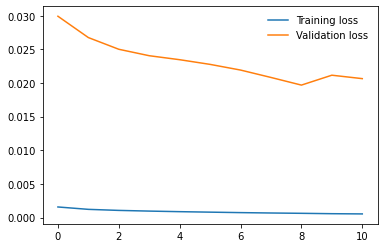

In [ ]:
model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=restart('m10')
graficoL(train_loss,val_loss)

A questo punto si abbassa il learning rate, con il criterio spiegato precedentemente, ottenendo un boost nelle performance fino all'80% dell'epoca 11.

Si mostra il grafico della loss all'epoca 11.

Carico il modello!


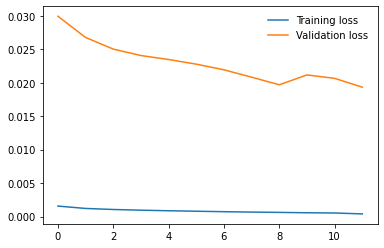

In [ ]:
model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=restart('m11')
graficoL(train_loss,val_loss)

Successivamente l'accuratezza cresce di un ulteriore 1% prima di iniziare a stabilizzarsi,il che consente di potersi fermare qui, presentando un modello a regime.

Si mostra il grafico della loss all'epoca 13.

Carico il modello!


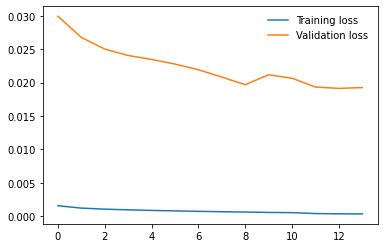

In [44]:
model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=restart('m13')
graficoL(train_loss,val_loss)

La loss del modello è abbastanza buona, assestandosi al valore di circa 0.020.

Dall'ultimo grafico,inerente all'epoca 13, si percepisce come anch'essa inizia a diventare costante ed è un olteriore indice che consente di fermarsi qui.



Questo grafico sintetizza il processo di apprendimento in termini di accuratezza.

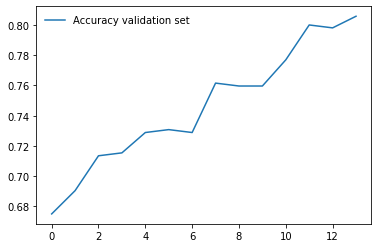

In [45]:
grafico(val_accs)

# **Test suite**

Vediamo ora come si comporta il modello proposto sul test set:

In [ ]:
model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=restart('m13')
testLoader=DataLoader(dataset=MyDataLoader(X_test,y_test,DATASET_FILES,0),batch_size=32)
y_true,y_pred=classify(model,testLoader,criterion)


Carico il modello!
L'accuratezza del test vale  81.78 % con una loss di  0.017


L'accuratezza sul test migliora di circa il 1% mentre la loss diminuisce di circa lo 0,003, un ottimo risultato!

Infatti, si può concludere che le tecniche utilizzate portano un boost sull'accuratezza di circa il 10% rispetto al modello originale S3D citato accademicamente e implementato nella repository github utilizzata.

Entrando più nel dettaglio:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       274
           1       0.78      0.83      0.80       297
           2       0.86      0.86      0.86      1832
           3       0.95      0.92      0.93      1101
           4       0.86      0.86      0.86       125
           5       0.86      0.87      0.87       704
           6       0.71      0.79      0.75      1051
           7       0.73      0.80      0.76       209
           8       0.77      0.76      0.77      1930
           9       0.82      0.78      0.80      3603

    accuracy                           0.82     11126
   macro avg       0.82      0.84      0.83     11126
weighted avg       0.82      0.82      0.82     11126



Il modello ha raggiunto 0,82 di avg precision, permettendo di superare le baseline progettuali richieste.

Vediamo ora gli errori commessi tramite una matrice di confusione opportunamente modificata, in modo tale da presentare il valore dei true positive sulla diagonale principale a zero e focalizzarsi sugli errori commessi per ogni classe.

Infatti, si normalizza il numero di errori sulla base del numero di sample appartenenti ad ogni categoria; mostrando la % di errori commessi su ogni categoria.



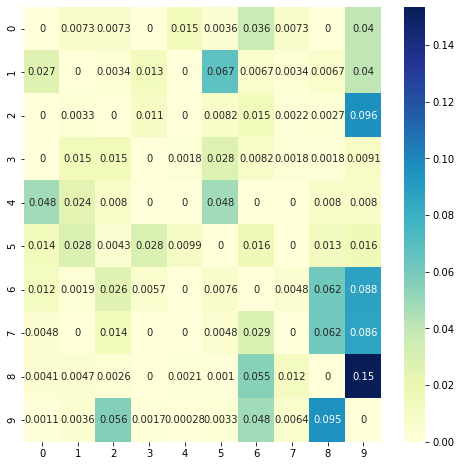

In [ ]:
conf_mx = confusion_matrix(y_true, y_pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
col_sum = conf_mx.sum(axis=0, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx)

Il modello sbaglia maggiormente sulla predizione delle classi 8 e 9, relative all'etichette no_action e walk, quelle con più sample nel dataset; come si intusice dai colori nelle colonne e nelle righe 8 e 9.

Molto probabilmente, le tecniche adottate vanno a favorire le classi in minoranza.

Una possibile features del modello, potrebbe riguardare l'opportuno trattamento di queste classi.

In conclusione, si presenta un modello S3D denominato m13.model, che tramite opportune tecniche di data augmentation e tramite il transfer learning sul kinetics 400, si presta in maniere eccellente all'analisi di frame video in formato mp4 riguardanti action recognition.